## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Cnidaria - Tim </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Chordata** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import layers, models, optimizers

2025-04-10 21:24:14.163716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744316654.178693   82968 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744316654.183070   82968 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744316654.195197   82968 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744316654.195222   82968 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744316654.195223   82968 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)


Memory growth set for GPUs


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Chordata Phylum.

In [3]:
# Load the DataFrame from the CSV file
cnidaria_train = pd.read_csv("train_test_splits/cnidaria_train_processed.csv")
cnidaria_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,resized_image,noBackground_image
0,28219388,45276311,animalia,cnidaria,acroporidae,cnidaria_acroporidae/28219388_45276311_eol-ful...,[[[76 74 72]\n [72 70 71]\n [76 72 74]\n .....,[[[ 0 0 0]\n [ 0 0 0]\n [ 0 0 ...
1,29729570,45276321,animalia,cnidaria,acroporidae,cnidaria_acroporidae/29729570_45276321_eol-ful...,[[[203 203 171]\n [196 189 159]\n [209 197 1...,[[[ 0 0 0]\n [141 188 211]\n [203 214 1...
2,20332243,46545536,animalia,cnidaria,lobophylliidae,cnidaria_lobophylliidae/20332243_46545536_eol-...,[[[ 9 159 90]\n [ 8 181 108]\n [ 2 212 1...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...


In [4]:
# Load the DataFrame from the CSV file
cnidaria_test = pd.read_csv("train_test_splits/cnidaria_test_processed.csv")
cnidaria_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,resized_image,noBackground_image
0,21699228,45276518,animalia,cnidaria,agariciidae,cnidaria_agariciidae/21699228_45276518_eol-ful...,[[[ 81 148 190]\n [ 83 150 192]\n [ 84 151 1...,[[[ 0 0 0]\n [ 0 0 0]\n [ 0 0 ...
1,2746810,45276959,animalia,cnidaria,siderastreidae,cnidaria_siderastreidae/2746810_45276959_eol-f...,[[[192 220 224]\n [193 221 225]\n [193 221 2...,[[[ 0 0 0]\n [ 0 0 0]\n [ 0 0 ...
2,29729172,45276583,animalia,cnidaria,fungiidae,cnidaria_fungiidae/29729172_45276583_eol-full-...,[[[126 145 82]\n [ 48 61 50]\n [ 48 57 ...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...


In [5]:
cnidaria_train.shape, cnidaria_test.shape

((647, 8), (162, 8))

In [6]:
cnidaria_train['family'].value_counts()

family
acroporidae         168
agariciidae          95
euphylliidae         72
faviidae             48
merulinidae          48
pocilloporidae       48
helioporidae         24
lobophylliidae       24
dendrophylliidae     24
siderastreidae       24
fungiidae            24
diploastraeidae      24
meandrinidae         24
Name: count, dtype: int64

In [7]:
cnidaria_train["family"].nunique()

13

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Assume your DataFrame columns are already set ---
# cnidaria_train contains:
#   - "noBackground_image": preprocessed image arrays (shape [224,224,3] for each)
#   - "family": the family label as a string
# And label_to_index and label_names are already defined.

# Convert the "noBackground_image" column to a stacked NumPy array for training and test images:
X_train = np.stack(cnidaria_train["noBackground_image"].values)
y_train = np.array([label_to_index[label] for label in cnidaria_train["family"]])

X_test  = np.stack(cnidaria_test["noBackground_image"].values)
y_test  = np.array([label_to_index[label] for label in cnidaria_test["family"]])

print("X_train shape:", X_train.shape)  # Should be (num_samples, 224, 224, 3)
print("X_test shape:", X_test.shape)

# --- Split Training Data into Train and Validation Sets (80/20 split) ---
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set size:", X_tr.shape[0])
print("Validation set size:", X_val.shape[0])

# --- Create TensorFlow Datasets from the NumPy Arrays ---

# For training dataset:
train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
train_ds = train_ds.shuffle(buffer_size=len(X_tr), seed=42)
train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# For validation dataset:
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# For test dataset:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)




NameError: name 'label_to_index' is not defined

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

## 4.2 Advanced Preprocessing

In [ ]:
#Define model shape
num_classes = cnidaria_train['family'].nunique() #number of classes = number of families
batch_size = 32
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

### Augmentation

In [ ]:
#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)

I0000 00:00:1744316510.977792   82552 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


### Pre-Process Pipeline

In [ ]:
#Function to preprocess the images
def process_image(file_path, label):
    image = tf.io.read_file(file_path) # Read the image file
    image = tf.image.decode_jpeg(image, channels=3) # Decode the JPEG image
    image = tf.image.resize(image, image_size) # Resize the image to the target size
    
    #CHANGE THIS LINE DEPENDING ON WHICH PRE-TRAINED MODEL IS BEING USED
    
    #image = resnet_preprocess(image)  # Apply ResNet50 preprocessing
    image = mobilenet_preprocess(image)  # Apply MobileNetV2 preprocessing
    #image = efficientnet_preprocess(image)  # Apply EfficientNetB0 preprocessing
    #image = densenet_preprocess(image)  # Apply DenseNet121 preprocessing
    #image = inception_preprocess(image)  # Apply InceptionV3 preprocessing
    #image = tf.cast(image, tf.float32) / 255.0  # Apply ConvNeXt
    return image, label

### Tensorflow data set

In [ ]:
import os
import tensorflow as tf

# --- Your existing steps for creating full paths and mapping labels ---
root_dir = "/root/DeepLearning2425/rare_species"

# Append full file paths to training and test DataFrames
cnidaria_train['full_path'] = cnidaria_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
cnidaria_test['full_path'] = cnidaria_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

file_paths_train = cnidaria_train['full_path'].tolist()
labels_train = cnidaria_train['family'].tolist()

file_paths_test = cnidaria_test['full_path'].tolist()
labels_test = cnidaria_test['family'].tolist()

# Map the labels to integers
label_names = sorted(set(labels_train))  # Get the unique labels
label_to_index = {name: i for i, name in enumerate(label_names)}  # Create a mapping from labels to integers
labels_train = [label_to_index[label] for label in labels_train]
labels_test = [label_to_index[label] for label in labels_test]

# print(file_paths_train[:5])
# print(labels_train[:5])
# print(file_paths_test[:5])
# print(labels_test[:5])

# # --- Calculate which classes are "minority" based on a threshold ---
# minority_threshold = 24
# family_counts = cnidaria_train['family'].value_counts()
# minority_families = family_counts[family_counts <= minority_threshold].index.tolist()
# minority_indices = [label_to_index[fam] for fam in minority_families if fam in label_to_index]
# print("Minority class indices:", minority_indices)
# minority_indices_tf = tf.constant(minority_indices, dtype=tf.int32)

# # --- Create the base dataset ---
# data = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
# data = data.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=False, seed=42)

# # --- Split train/val ---
# train_size = int(0.8 * len(file_paths_train))  # 80% for training, 20% for validation
# train = data.take(train_size)
# val = data.skip(train_size)

# # --- Oversampling Minority Classes ---
# oversample_factor = 2  # Adjust this factor as desired

# # Filter the training dataset into minority and majority subsets
# minority_ds = train.filter(lambda fp, label: tf.reduce_any(tf.equal(label, minority_indices_tf)))
# majority_ds = train.filter(lambda fp, label: tf.logical_not(tf.reduce_any(tf.equal(label, minority_indices_tf))))

# # Repeat the minority dataset to oversample it
# minority_ds = minority_ds.repeat(oversample_factor)

# # Concatenate the majority and oversampled minority datasets
# # Note: It's advisable to re-shuffle after concatenation
# train = majority_ds.concatenate(minority_ds)
# train = train.shuffle(buffer_size=train_size, reshuffle_each_iteration=True, seed=42)

# # --- Training Preprocess Pipeline ---
# train = train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# train = train.cache()
# # Use your augmentation function here; if you want targeted augmentation instead, replace with conditional_augment.
# train = train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
# train = train.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# # --- Validation Preprocess Pipeline ---
# val = val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# val = val.cache()
# val = val.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# # --- Test Preprocess Pipeline ---
# test = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
# test = test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# test = test.cache().batch(8).prefetch(tf.data.AUTOTUNE)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume that your DataFrame (cnidaria_train and cnidaria_test) is already updated
# with a "noBackground_image" column that contains NumPy arrays.
# And that cnidaria_train['family'] contains the family labels.
# Also assume label_to_index mapping and label_names are already defined.

# For training data:
X_train = np.stack(cnidaria_train["noBackground_image"].values)
y_train = np.array([label_to_index[label] for label in cnidaria_train["family"]])

# For test data:
X_test = np.stack(cnidaria_test["noBackground_image"].values)
y_test = np.array([label_to_index[label] for label in cnidaria_test["family"]])

# Split the training data into train and validation sets (80%/20% split)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_tr shape:", X_tr.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

# Create TensorFlow datasets from NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
train_ds = train_ds.shuffle(buffer_size=len(X_tr), seed=42).batch(8).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)

X_tr shape: (517,)
X_val shape: (130,)
X_test shape: (162,)


In [ ]:
# import os
# import math
# import tensorflow as tf
# import pandas as pd

# # --- Your existing dataset creation ---
# root_dir = "/root/DeepLearning2425/rare_species"

# # Construct full file paths for train and test DataFrames.
# cnidaria_train['full_path'] = cnidaria_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
# cnidaria_test['full_path']  = cnidaria_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

# file_paths_train = cnidaria_train['full_path'].tolist()
# labels_train = cnidaria_train['family'].tolist()

# file_paths_test = cnidaria_test['full_path'].tolist()
# labels_test = cnidaria_test['family'].tolist()

# # Map the labels to integers.
# label_names = sorted(set(labels_train))  # Unique family names sorted alphabetically.
# label_to_index = {name: i for i, name in enumerate(label_names)}
# labels_train = [label_to_index[label] for label in labels_train]
# labels_test  = [label_to_index[label] for label in labels_test]

# print("Sample train paths:", file_paths_train[:5])
# print("Sample train labels:", labels_train[:5])
# print("Sample test paths:", file_paths_test[:5])
# print("Sample test labels:", labels_test[:5])

# # Create the initial dataset.
# data = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
# data = data.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=False, seed=42)

# # --- Split train and validation ---
# train_size = int(0.8 * len(file_paths_train))  # 80% for training, 20% for validation
# train = data.take(train_size)
# val = data.skip(train_size)

# # --- Compute label distribution in training set ---
# train_labels = []
# for _, label in train:
#     train_labels.append(label.numpy())
# train_labels = pd.Series(train_labels)
# train_distribution = train_labels.value_counts().sort_index()
# # Map integer index back to family names for display.
# train_distribution.index = [label_names[i] for i in train_distribution.index]
# print("Training set label distribution:")
# print(train_distribution)

# # --- Compute oversampling factors: ---
# # Determine the count of the majority class.
# max_count = train_distribution.max()
# # For each class, the factor to oversample is the ceiling of (max_count / class_count).
# oversampling_factors = {fam: math.ceil(max_count / count) for fam, count in train_distribution.items()}
# print("Oversampling factors:")
# print(oversampling_factors)

# # --- Build balanced training dataset via oversampling ---
# # For each unique class label, create a dataset filtered by that label and repeat it.
# oversampled_ds_list = []
# for class_idx in sorted(train_labels.unique()):
#     # Find the class name from the mapping.
#     class_name = label_names[class_idx]
#     factor = oversampling_factors[class_name]
#     ds_class = train.filter(lambda fp, label, ci=class_idx: tf.equal(label, ci))
#     ds_class = ds_class.repeat(factor)  # Repeat this subset 'factor' times.
#     oversampled_ds_list.append(ds_class)

# # Concatenate all oversampled class datasets together.
# balanced_train = oversampled_ds_list[0]
# for ds in oversampled_ds_list[1:]:
#     balanced_train = balanced_train.concatenate(ds)

# # Shuffle the balanced training dataset again.
# balanced_train = balanced_train.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed=42)

# # --- Continue with your preprocessing pipeline ---
# # Assume process_image and augment_image are defined earlier.
# balanced_train = balanced_train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# balanced_train = balanced_train.cache()
# balanced_train = balanced_train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
# balanced_train = balanced_train.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# # Validation pipeline remains unchanged.
# val = val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# val = val.cache()
# val = val.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# # Test pipeline remains unchanged.
# test = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
# test = test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# test = test.cache().batch(8).prefetch(tf.data.AUTOTUNE)


# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

## 5.1 Baseline MobileNetV2

### Model Setup

In [ ]:
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Load base model without top layer
base_model = MobileNetV2(
    input_shape=input_shape,  # Match your resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet-pretrained weights
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

model = models.Sequential([
    base_model,                                # Pre-trained feature extractor
    layers.GlobalAveragePooling2D(),           # Pool the spatial features
    layers.Dropout(0.3),                       # Dropout for regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularized Dense layer
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer with L2 regularizer
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Use a lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,629 (9.25 MB)

 Trainable params: 165,645 (647.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Model Training

In [ ]:
y_train = np.array(labels_train)  # Replace labels_train with your training label list
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

Computed class weights: {0: np.float64(0.29624542124542125), 1: np.float64(0.5238866396761134), 2: np.float64(2.073717948717949), 3: np.float64(2.073717948717949), 4: np.float64(0.6912393162393162), 5: np.float64(1.0368589743589745), 6: np.float64(2.073717948717949), 7: np.float64(2.073717948717949), 8: np.float64(2.073717948717949), 9: np.float64(2.073717948717949), 10: np.float64(1.0368589743589745), 11: np.float64(1.0368589743589745), 12: np.float64(2.073717948717949)}


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

#callbacks
checkpoint = ModelCheckpoint(
    "models/cnidaria_models/finetuned_best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=40,           # Start small, increase if needed
        verbose=1
    )

#save the model
model.save("models/cnidaria_models/finetuned_model.keras")

Epoch 1/40


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=True
  • mask=None

In [ ]:
#get the best accuracy score
best_accuracy = max(history.history['val_accuracy'])
print("Best validation accuracy:", best_accuracy)

Best validation accuracy: 0.4076923131942749


### Result Visualizations

In [ ]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


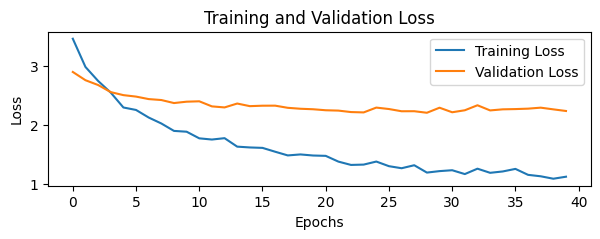

In [ ]:
plot_loss(history)

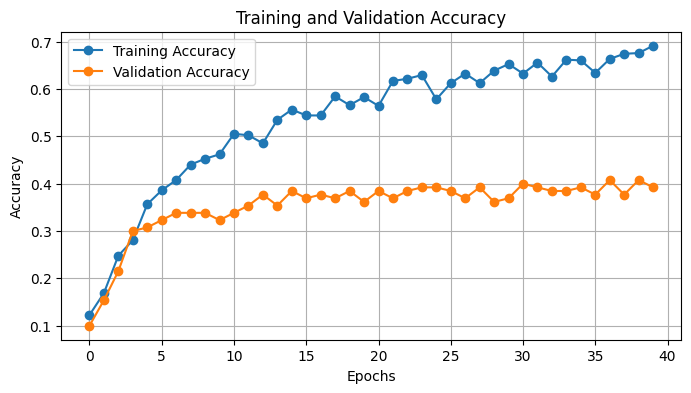

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step


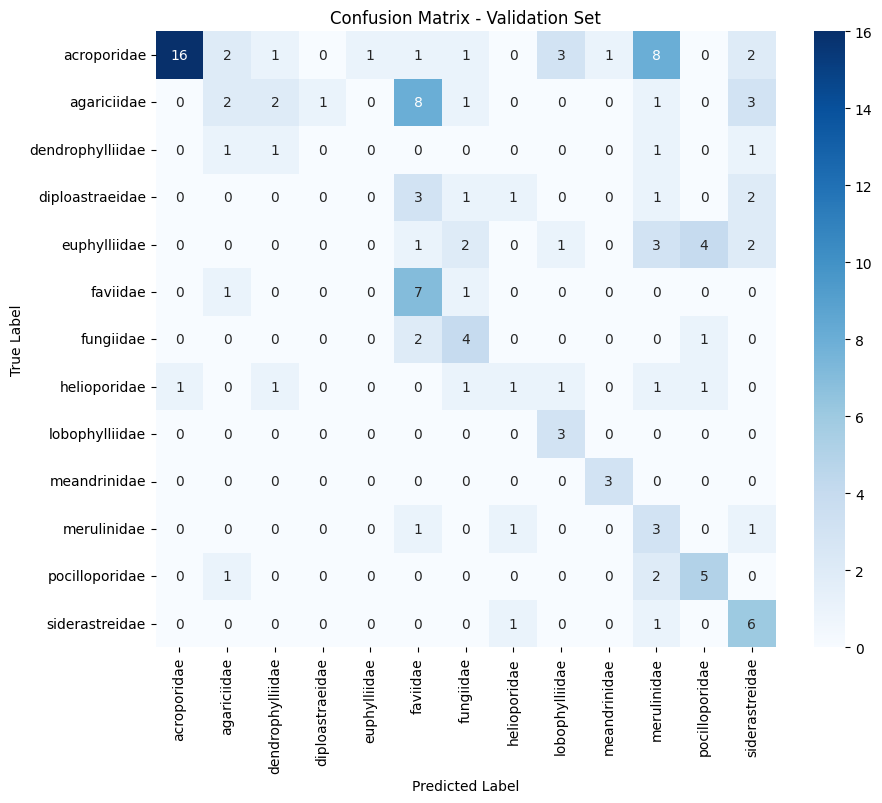

                  precision    recall  f1-score   support

     acroporidae       0.94      0.44      0.60        36
     agariciidae       0.29      0.11      0.16        18
dendrophylliidae       0.20      0.25      0.22         4
 diploastraeidae       0.00      0.00      0.00         8
    euphylliidae       0.00      0.00      0.00        13
        faviidae       0.30      0.78      0.44         9
       fungiidae       0.36      0.57      0.44         7
    helioporidae       0.25      0.14      0.18         7
  lobophylliidae       0.38      1.00      0.55         3
    meandrinidae       0.75      1.00      0.86         3
     merulinidae       0.14      0.50      0.22         6
  pocilloporidae       0.45      0.62      0.53         8
  siderastreidae       0.35      0.75      0.48         8

        accuracy                           0.39       130
       macro avg       0.34      0.47      0.36       130
    weighted avg       0.44      0.39      0.36       130



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the validation set
# This returns probabilities, so we use argmax to obtain predicted class indices.
y_val_pred_probs = model.predict(val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Extract the true labels from the validation dataset
y_val_true = []
for images, labels in val:
    # Convert labels from a tensor to a NumPy array and extend our list.
    y_val_true.extend(labels.numpy())
y_val_true = np.array(y_val_true)

# Compute the confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Optional: if you have the label names (sorted list of unique labels), use them for tick labels
# For example, if defined earlier:
# label_names = sorted(set(labels_train))
# If not, you can omit xticklabels and yticklabels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Print a detailed classification report
print(classification_report(y_val_true, y_val_pred, target_names=label_names))
